In [ ]:
# Calculate the signed distance function image of the road mask

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def generate_sdf(binary_mask):
    """
    生成 SDF 掩码，要求在道路内部为正值，外部为负值，道路边缘为0。
    Args:
        binary_mask (np.ndarray): 二值化的道路掩码，1 表示道路，0 表示背景。
    Returns:
        sdf (np.ndarray): SDF 掩码，内部为正值，外部为负值，边缘为 0。
    """

    # 输入应该是二值化的 mask，1 表示道路区域，0 表示背景区域
    assert binary_mask.dtype == np.uint8, "输入掩码应为 uint8 类型"

    # 计算道路内部到边缘的距离（正值）
    dist_to_road = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # 计算背景到边缘的距离（负值）
    dist_to_background = cv2.distanceTransform(255 - binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # SDF 掩码：道路区域为正值，背景为负值，边缘为 0
    sdf = dist_to_road - dist_to_background

    return sdf

path_list = ["/home/fk/python_code/datasets/dataset_sz_grid/train_val/mask",
             "/home/fk/python_code/datasets/dataset_sz_grid/test/mask",
             "/home/fk/python_code/datasets/dataset_bj_time/train_val/mask",
             "/home/fk/python_code/datasets/dataset_bj_time/test/mask"]

for path in path_list:
    save_path = os.path.join(path[:path.rfind('/')] , f"{path.split('/')[-1]}_sdf_T")
    os.makedirs(save_path, exist_ok=True)
    jet_save_path = os.path.join(path[:path.rfind('/')] , f"{path.split('/')[-1]}_jet")
    os.makedirs(jet_save_path, exist_ok=True)
    for file_name in tqdm(os.listdir(path, )):
        road_mask = cv2.imread(os.path.join(path, file_name), 0)  # 0表示灰度图读取

        # 计算符号距离函数
        sdf_mask = generate_sdf(road_mask)
        np.save(os.path.join(save_path, file_name.split(".")[0]), sdf_mask)

        # 可视化SDF图像
        # sdf_min = np.min(sdf_mask)
        # sdf_max = np.max(sdf_mask)
        # sdf_normalized = 2 * (sdf_mask - sdf_min) / (sdf_max - sdf_min) - 1 # 归一化到[-1, 1]范围

        # plt.imshow(sdf_mask, cmap='seismic', origin='lower')  # 使用'seismic'色彩图，正值为红色，负值为蓝色
        # plt.colorbar(label='SDF Values')  # 添加色条表示不同数值
        # plt.title('SDF Visualization')

        # # 保存图像
        # plt.savefig(os.path.join(jet_save_path, file_name))
        # plt.show()


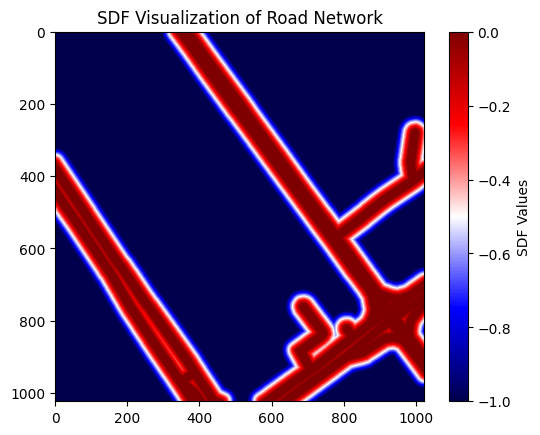

In [17]:
# try scipy
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import torch

def binary_mask_to_sdf(mask):
    """
    将二值道路网络 mask 转换为带有正负值的 SDF mask。

    参数：
    - mask: numpy 数组，表示二值化的道路网络 mask（1 表示道路，0 表示非道路）

    返回：
    - sdf_mask: numpy 数组，表示 SDF mask，正值表示非道路到道路的距离，负值表示道路到非道路的距离
    """
    # 计算距离变换：非道路区域到最近道路像素的距离
    dist_to_road = distance_transform_edt(mask == 0)

    # 计算距离变换：道路区域到最近非道路像素的距离
    dist_to_non_road = distance_transform_edt(mask == 1)

    # 将道路区域的距离设为负值，非道路区域为正值
    # sdf_mask = dist_to_road - dist_to_non_road
    sdf_mask = dist_to_non_road - dist_to_road

    return sdf_mask

# 示例使用
# 创建一个简单的二值化道路网络 mask (1 表示道路，0 表示非道路)
binary_mask = cv2.imread('/home/fk/python_code/datasets/dataset_sz_grid/train_val/mask/8_6_mask.png', cv2.IMREAD_GRAYSCALE)

# 将二值道路网络转换为 SDF mask
sdf_mask = binary_mask_to_sdf(binary_mask)

# 将 SDF mask 归一化到 [0, 1] 范围
delta = 40
if delta == 0:
    delta = 1
sdf_clamp = torch.clamp(torch.tensor(sdf_mask), min=-delta, max=delta) / delta

sdf_clamp = sdf_clamp.numpy()

# 可视化 SDF mask
plt.imshow(sdf_clamp, cmap='seismic')
plt.colorbar(label='SDF Values')
plt.title('SDF Visualization of Road Network')
plt.show()


In [22]:
# Fingding the best threshold value for SDF mask

import cv2
import numpy as np
import torch

# threshold_value = np.arange(5,30)
threshold_value = [0]

mask = cv2.imread('/home/fk/python_code/datasets/dataset_bj_time/train_val/mask/2_16_mask.png', cv2.IMREAD_GRAYSCALE)
mask = mask/255.0

# 读取并归一化后的SDF图像 (已经是uint8类型，范围为0-255)
# sdf_normalized = cv2.normalize(sdf, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# sdf_image = cv2.imread("/home/fk/python_code/traj/data_prepare/save_images/sdf_road_highlight.png", 0)
sdf_mask = np.load("/home/fk/python_code/datasets/dataset_bj_time/train_val/mask_sdf_T/2_16_mask.npy")

for threshold in threshold_value:

    #将SDF图像进行二值化处理
    # _, binary_road_map = cv2.threshold(sdf_mask, thresh, 255, cv2.THRESH_BINARY)
    binary_road_map = np.where(sdf_mask > threshold, 1, 0)

    # 显示或保存结果
    cv2.imwrite('../save_images/binary_road_network.png', binary_road_map)

    # 计算IoU指标
    intersection = np.logical_and(mask, binary_road_map)
    union = np.logical_or(mask, binary_road_map)
    iou_score = np.sum(intersection) / np.sum(union)

    print(f"阈值为 {threshold} 时，IoU指标为 {iou_score:.4f}")


阈值为 0 时，IoU指标为 1.0000


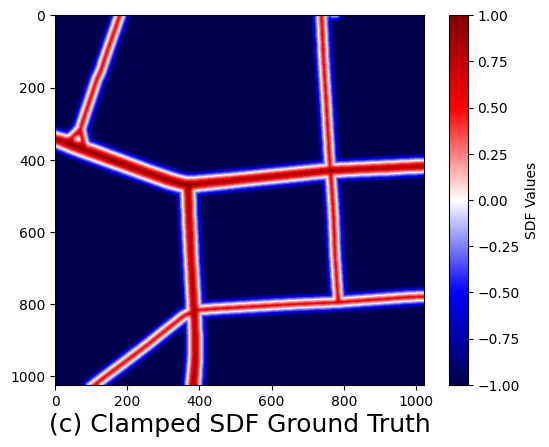

In [23]:
#vilization of SDF mask
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

sdf_mask = np.load("/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_T/2024_6_mask.npy")
# sdf_mask = np.load("/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_T/2003_4_mask.npy")
# sdf_mask = np.load("/home/fk/python_code/traj/weights_sz_sdf_seed_0/prediction_npy/2020_4.npy")

delta = 20
if delta == 0:
    delta = 1
sdf_clamp = torch.clamp(torch.tensor(sdf_mask), min=-delta, max=delta) / delta

sdf_clamp = sdf_clamp.numpy()

plt.imshow(sdf_clamp, cmap='seismic', origin='upper')  # 使用'seismic'色彩图，正值为红色，负值为蓝色
# plt.axis('off') # 不显示坐标轴
plt.colorbar(label='SDF Values')  # 添加色条表示不同数值
plt.title('(c) Clamped SDF Ground Truth', fontsize=18, y=-0.15)

# plt.savefig(os.path.join(jet_save_path, file_name)) # 保存图像
plt.show()


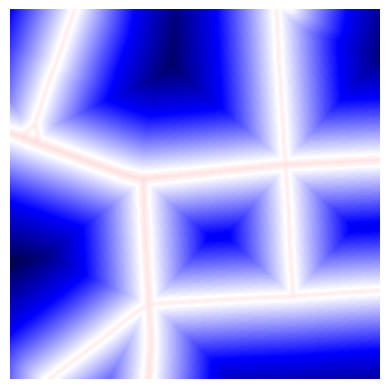

In [25]:
# Visualization of SDF mask with SymLogNorm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# 加载 SDF mask
sdf_mask = np.load("/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_T/2024_6_mask.npy")
# sdf_mask = np.load("/home/fk/python_code/traj/weights_sz_sdf_delta/dlink34_sat_gpsimage_sdf_filtered_gaussian_ltqs_log_20_mse_dice_bce_loss_1.0__/prediction_npy/2003_6.npy")

# 获取 SDF mask 的绝对最大值，用于对称归一化
max_abs_value = np.max(np.abs(sdf_mask))

# 使用 SymLogNorm 确保零值显示为白色
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

# 显示图像

plt.imshow(sdf_mask, cmap='seismic', norm=norm, origin='upper')  # 使用 seismic 色彩图
plt.axis('off')  # 不显示坐标轴
# plt.colorbar(label='SDF Values')  # 添加色条表示不同数值
# plt.title('(a) SDF Ground Truth', fontsize=18, y=-0.15)
plt.show()


In [4]:
# clamp the SDF mask
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# file_path = "/home/fk/python_code/traj/weights_sz_sdf_seed_0/prediction_npy"
file_path = "/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_T"
save_path = "/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_clamped"
# save_path = "/home/fk/python_code/traj/weights_sz_sdf_seed_0/prediction_npy_jet"
os.makedirs(save_path, exist_ok=True)
file_list = os.listdir(file_path)
for file_name in tqdm(file_list):
    sdf_mask = np.load(f"{file_path}/{file_name}")
    delta = 25
    if delta == 0:
        delta = 1
    sdf_clamp = torch.clamp(torch.tensor(sdf_mask), min=-delta, max=delta) / delta

    sdf_clamp = sdf_clamp.numpy()
    np.save(os.path.join(save_path, file_name.split(".")[0]), sdf_clamp)

100%|██████████| 152/152 [00:00<00:00, 155.44it/s]


In [ ]:
#vilization of SDF mask and persistence
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# file_path = "/home/fk/python_code/traj/weights_sz_sdf_seed_0/prediction_npy"
file_path = "/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_T"
save_path = "/home/fk/python_code/datasets/dataset_sz_grid/test/mask_sdf_clamped_jet"
# save_path = "/home/fk/python_code/traj/weights_sz_sdf_seed_0/prediction_npy_jet"
os.makedirs(save_path, exist_ok=True)
file_list = os.listdir(file_path)
for file_name in tqdm(file_list):
    sdf_mask = np.load(f"{file_path}/{file_name}")
    delta = 25
    if delta == 0:
        delta = 1
    sdf_clamp = torch.clamp(torch.tensor(sdf_mask), min=-delta, max=delta) / delta

    sdf_clamp = sdf_clamp.numpy()

    plt.imshow(sdf_clamp, cmap='seismic', origin='upper')  # 使用'seismic'色彩图，正值为红色，负值为蓝色
    # plt.axis('off') # 不显示坐标轴
    plt.colorbar(label='SDF Values')  # 添加色条表示不同数值
    plt.title('SDF Visualization')

    plt.savefig(os.path.join(save_path, file_name.split(".")[0])) # 保存图像
    plt.cla()
    plt.clf()
    plt.close()

    # plt.show()


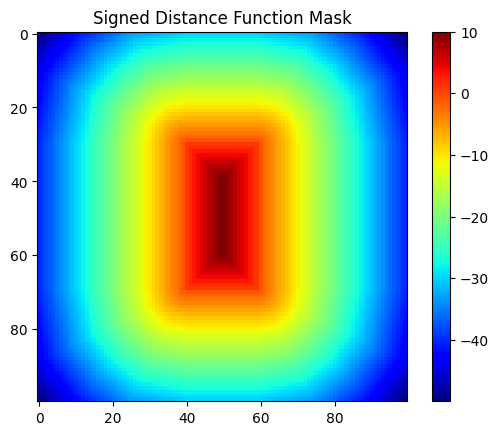

In [ ]:
# Just a sample for test
import numpy as np
import cv2

def generate_sdf(binary_mask):
    """
    生成 SDF 掩码，要求在道路内部为正值，外部为负值，道路边缘为0。

    Args:
        binary_mask (np.ndarray): 二值化的道路掩码，1 表示道路，0 表示背景。

    Returns:
        sdf (np.ndarray): SDF 掩码，内部为正值，外部为负值，边缘为 0。
    """
    # 输入应该是二值化的 mask，1 表示道路区域，0 表示背景区域
    assert binary_mask.dtype == np.uint8, "输入掩码应为 uint8 类型"

    # 计算道路内部到边缘的距离（正值）
    dist_to_road = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # 计算背景到边缘的距离（负值）
    dist_to_background = cv2.distanceTransform(1 - binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # SDF 掩码：道路区域为正值，背景为负值，边缘为 0
    sdf = dist_to_road - dist_to_background

    return sdf


import matplotlib.pyplot as plt

# 假设 binary_mask 是一个二值化的道路掩码
binary_mask = np.zeros((100, 100), dtype=np.uint8)
binary_mask[30:70, 40:60] = 1  # 模拟一条道路

# 生成 SDF 掩码
sdf_mask = generate_sdf(binary_mask)

# 可视化 SDF 掩码
plt.imshow(sdf_mask, cmap='jet')
plt.colorbar()
plt.title('Signed Distance Function Mask')
plt.show()
